In [ ]:
# execute this line on terminal before running
# pip install -r requirements.txt

# Librerías

In [1]:
# packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

from utils.resample import resample
from utils.evaluate_model import evaluate_model
from utils.optimize_xgboost import optimize_xgboost
from utils.optimize_lgbm import optimize_lgbm
from utils.plot_ratio import plot_ratio
from utils.cramers_v import cramers_v
from utils.plot_cramer import plot_cramer

# seed
random_state = 3380

# supress warnings
import warnings
warnings.filterwarnings("ignore")

from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

/Users/stino/opt/anaconda3/envs/latam_challenge/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data ingestion

In [2]:
# read data
df = pd.read_csv('challenge/dataset_SCL.csv', sep = ',', dtype = {'Vio-I': 'category', 'Ori-I': 'category', 'Des-I': 'category',
                                                                  'Emp-I': 'category', 'Vio-O': 'category', 'Ori-O': 'category',
                                                                  'Des-O': 'category', 'Emp-O': 'category', 'DIANOM': 'category',
                                                                  'TIPOVUELO': 'category', 'OPERA': 'category', 'SIGLAORI': 'category',
                                                                  'SIGLADES': 'category', 
                                                                  #'DIA': 'category', 'MES': 'category', 'AÑO': 'category',
                                                                  })

# transform to datetime format
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# for better understanding
df['TIPOVUELO'] = df['TIPOVUELO'].apply(lambda x: 'Domestic' if x == 'N' else 'International' if x == 'I' else x)

# sample of data
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,International,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,International,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,International,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,International,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,International,American Airlines,Santiago,Miami


# 1. ¿How is the data distributed? 

In [3]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} features!')

The dataset contains 68206 rows and 18 features!


Let´s visualize the distribution of the departures:

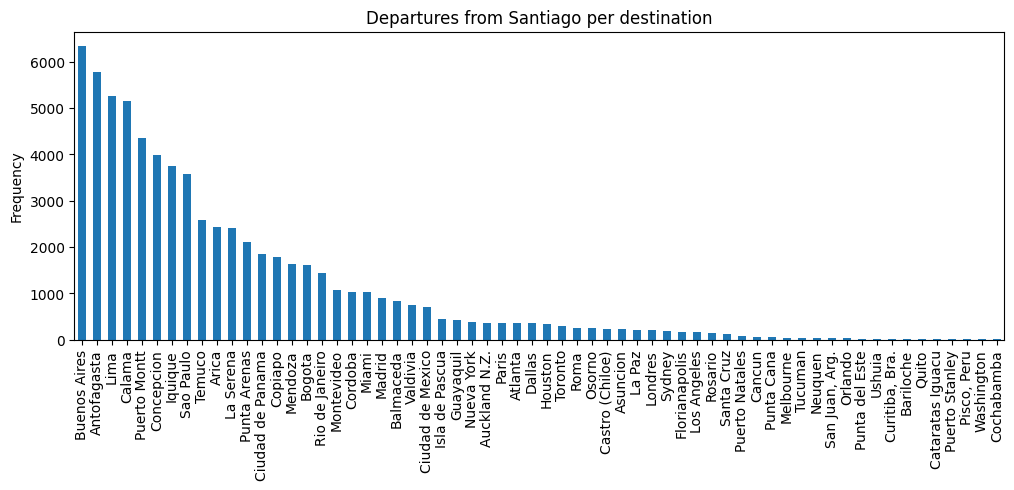

In [4]:
plt.figure(figsize = (12, 4))
df['SIGLADES'].value_counts().plot.bar()
plt.title('Departures from Santiago per destination')
plt.ylabel('Frequency')
plt.show()

Apparently, the departures from Santiago are concentrated on destinations within `South America`. On that regard, it is noted that the majority of flights are local, with some exceptions like departures to `Buenos Aires` or `Lima`.

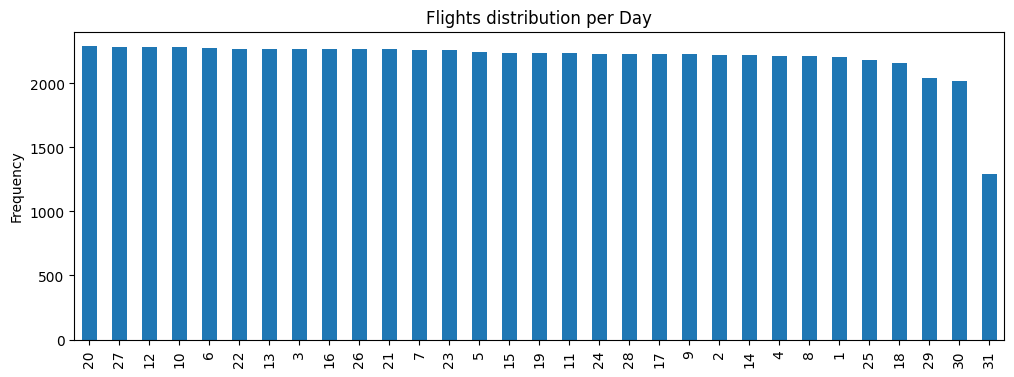

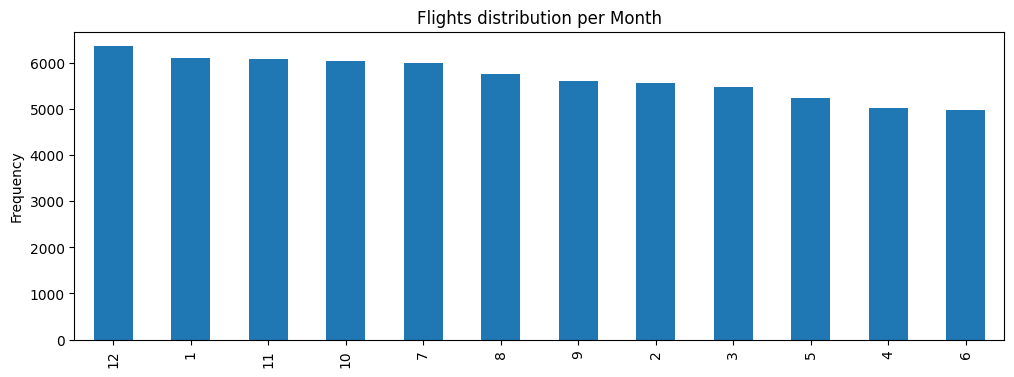

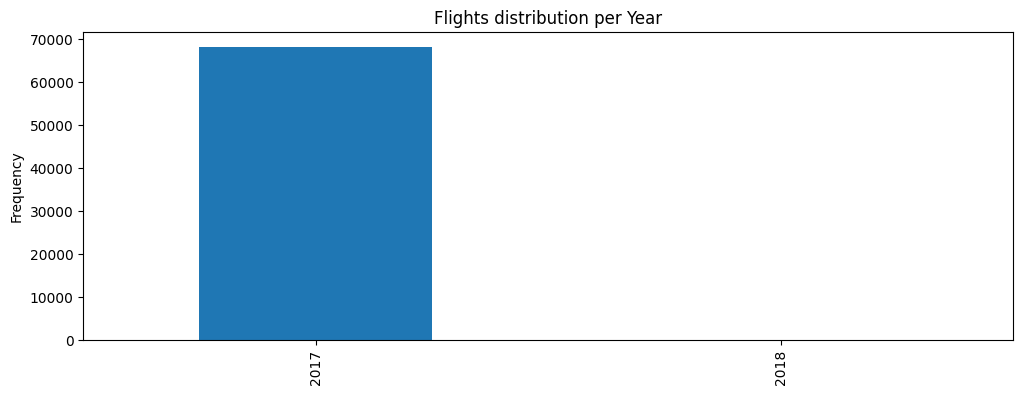

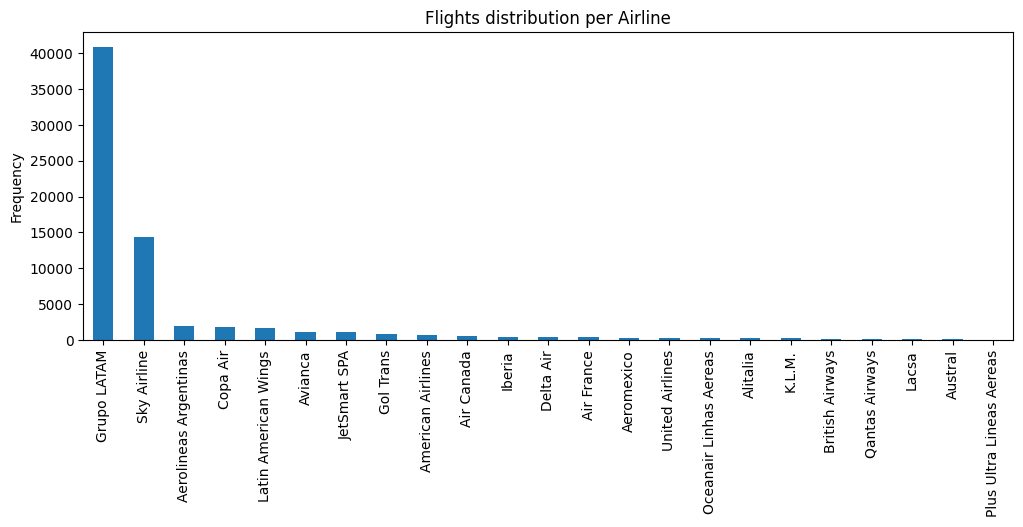

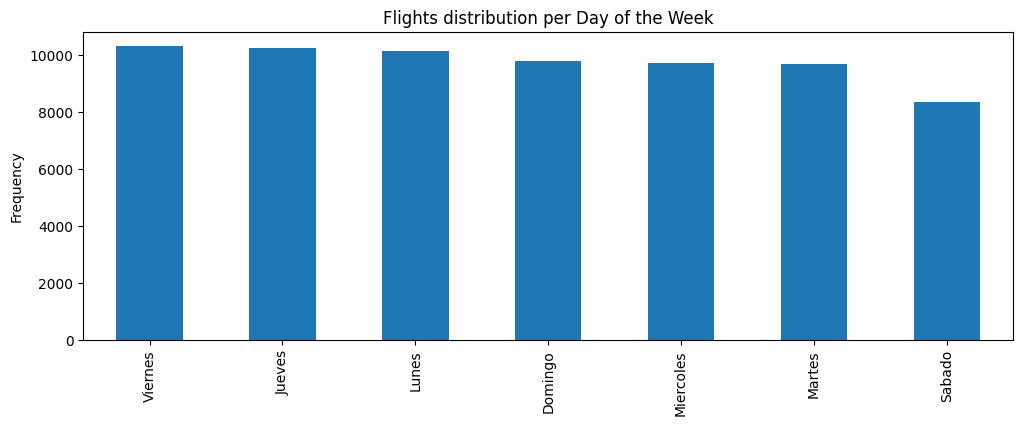

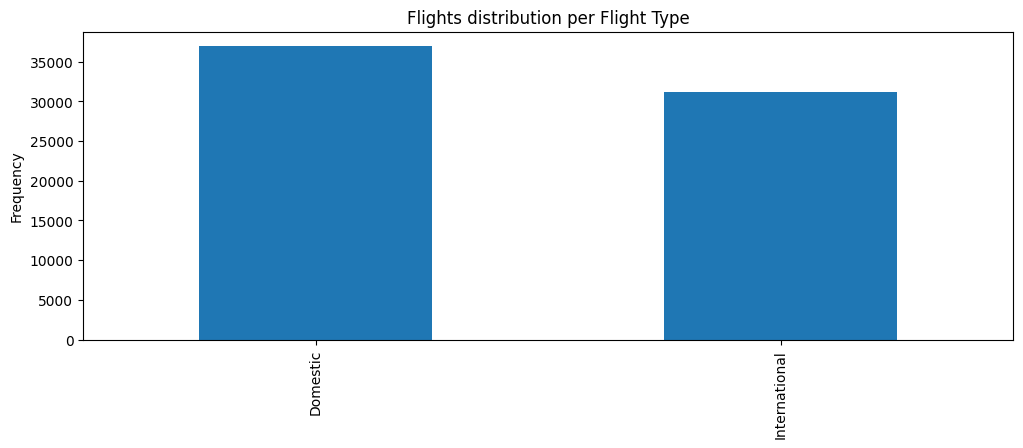

In [5]:
plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Day')
df['DIA'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Month')
df['MES'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Year')
df['AÑO'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Airline')
df['OPERA'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Day of the Week')
df['DIANOM'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (12, 4))
plt.title('Flights distribution per Flight Type')
df['TIPOVUELO'].value_counts().plot.bar()
plt.ylabel('Frequency')
plt.show()

From the generated graphs, the following findings can be highlighted:

- The number of trips per day of the month (`DIA`) is distributed relatively evenly, with a slight decrease in the last days of the month. This variation can be explained because the last days of the month (`29`, `30`, and `31`) do not occur in all months of the year.
- The number of trips per month (`MES`) has slight differences between each month, with December, January, and July having the highest number of flights.
- The number of trips per year (`AÑO`) is almost entirely concentrated in the year 2017, with only 2 trips out of the 68,206 in the dataset belonging to the year 2018.
- It can be seen that `Grupo lATAM` and `SKY Airline` are the two main airlines with the highest number of flights at Santiago airport. This is expected since they are the two largest airlines in the country, both in terms of fleet size and passenger traffic.
- There is a higher number of flights on `Viernes`, `Jueves`, and `Lunes`. Additionally, there is a significant decrease in the number of flights on `Sabado`.
- There are more `Domestic` flights than `International` flights.

Next, it is possible to analyze the relation between the categorical variables at disposal. 

In that sense, a heatmap based on `Cramer's V` is a useful way to visualize the association between two categorical variables. `Cramer's V` is a measure of association between two categorical variables, which ranges from 0 to 1. It takes into account the number of categories and the size of the sample to determine the strength of the association. A value of 0 indicates no association, while a value of 1 indicates a perfect association.

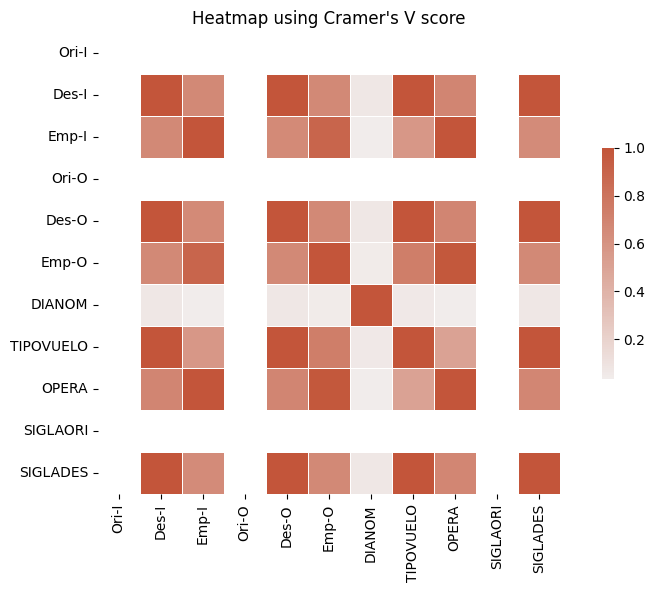

In [6]:
# Cramer score
plot_cramer(df, df.select_dtypes('category').columns)

Based on the heatmap, we can draw the following conclusions:

- The Programmed features and Operation features (such as `Des-I` and `Des-O`) are strongly correlated. This is not surprising since these characteristics are usually the same unless there is a significant reason to deviate from the planned schedule, such as weather or mechanical issues.
- Similarly, there is a strong relationship between `TIPOVUELO` and the destination (both `Des-I` and `Des-O`). This is to be expected because the destination determines whether the flight is categorized as National or Domestic.
- `DIANOM` is weakly correlated with the other features, suggesting that the day of the week does not have a significant impact on the distribution of flight characteristics.

Finally, let's study the missing values:

In [7]:
df.isnull().sum().sort_values(ascending = False)

Vlo-O        1
Fecha-I      0
DIA          0
SIGLAORI     0
OPERA        0
TIPOVUELO    0
DIANOM       0
AÑO          0
MES          0
Emp-O        0
Vlo-I        0
Des-O        0
Ori-O        0
Fecha-O      0
Emp-I        0
Des-I        0
Ori-I        0
SIGLADES     0
dtype: int64

We observe that there is only one missing value in the `Vlo-O` column. To address this, we will impute this data in the training set using `SimpleImputer`.

# 2. Generate new features

After studying the dataset, we can generate some features that may prove useful in predicting flight delays:

In [8]:
# we define date variables
dec_15 = datetime.date(2017, 12, 15) # Dec-15 2017
mar_3 = datetime.date(2017, 3, 3) # Mar-3 2017
jul_15 = datetime.date(2017, 7, 15) # Jul-15 2017
jul_31 = datetime.date(2017, 7, 31) # Jul-31 2017
sep_11 = datetime.date(2017, 9, 11) # Sep-11 2017
sep_30 = datetime.date(2017, 9, 30) # Sep-30 2017
mar_3_2018 = datetime.date(2018, 3, 3) # Mar-3 2018

# and time variables
am_5 = datetime.time(5, 0) # 5:00 am
am_11 = datetime.time(11, 59) # 11:59 am
pm_12 = datetime.time(12, 0) # 12:00 pm
pm_18 = datetime.time(18, 59) # 18:59 pm
pm_19 = datetime.time(19, 0) # 19:00 pm
am_4 = datetime.time(4, 59) # 4:59 am

# high_season
df['high_season'] = df['Fecha-I'].apply(lambda x: 1 if (x.date() >= dec_15 or x.date() <= mar_3) 
                                        | (x.date() >= jul_15 and x.date() <= jul_31) 
                                        | (x.date() >= sep_11 and x.date() <= sep_30) 
                                        | (x.year == 2018 and x.date() <= mar_3_2018) # border case from 2 obs belonging to 2018
                                        else 0) 

# min_diff
df['min_diff'] = df.apply(lambda x: (x['Fecha-O'] - x['Fecha-I']).total_seconds() / 60, axis = 1)

# delay_15
df['delay_15'] = np.where(df['min_diff'] > 15, 1, 0)

# period_day
df['period_day'] = df['Fecha-I'].apply(lambda x: 'morning' if (x.time() >= am_5 and x.time() <= am_11) else 
                                       'afternoon' if (x.time() >= pm_12 and x.time() <= pm_18) else
                                       'night' if (x.time() >= pm_19 or x.time() <= am_4)
                                       else np.nan)

# export as csv
new_features = ['high_season', 'min_diff', 'delay_15', 'period_day']
df[['Fecha-I', 'Fecha-O'] + new_features].to_csv('generated_data/synthetic_features.csv', sep = ';', encoding = 'utf-8-sig', index = False)

# 3. Behavior of delay rate across features

From this point onwards, it will be assumed that we want to study flights that have a delay of 15 minutes or more (`delay_15`).

First, we will study the distribution of the `delay_15` variable:

0    0.81506
1    0.18494
Name: delay_15, dtype: float64


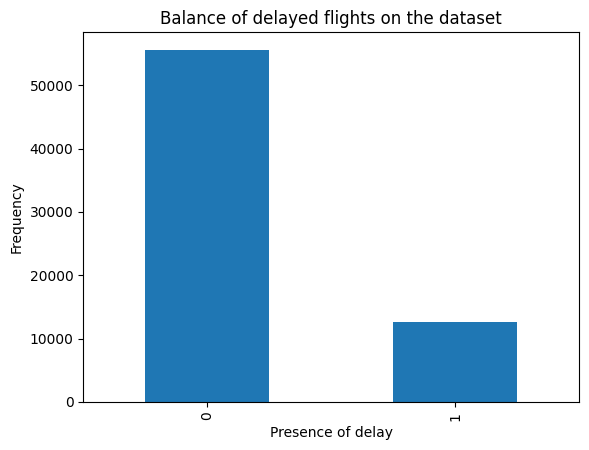

In [9]:
print(df['delay_15'].value_counts() / df.shape[0])

df['delay_15'].value_counts().plot.bar()
plt.title('Balance of delayed flights on the dataset')
plt.xlabel('Presence of delay')
plt.ylabel('Frequency')
plt.show()

We observe that the `delay_15` class is unbalanced in favor of flights without delay (label 0), accounting for 81.5% of the sample data, in contrast to 18.5% of the data representing delayed flights.

Let's now plot the distribution of `delay_15` against other features:

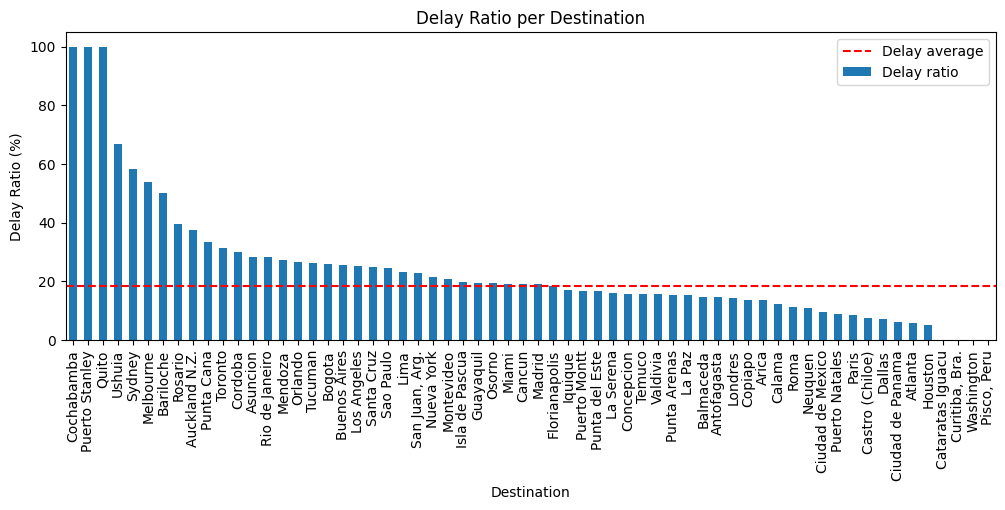

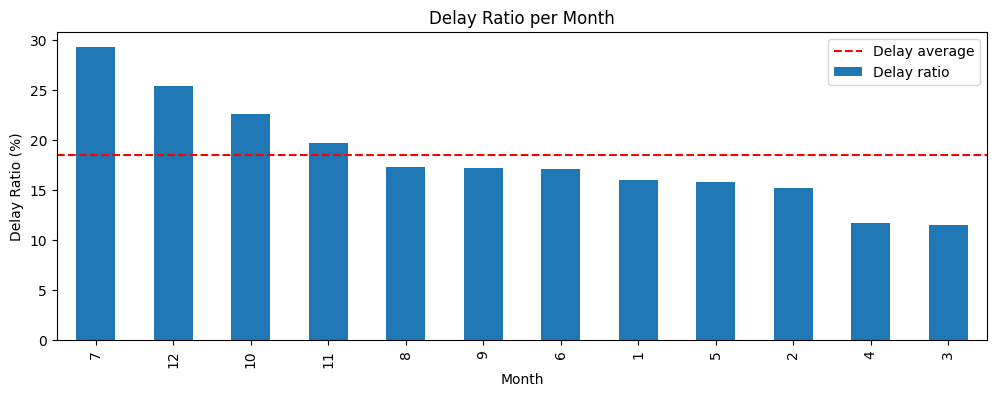

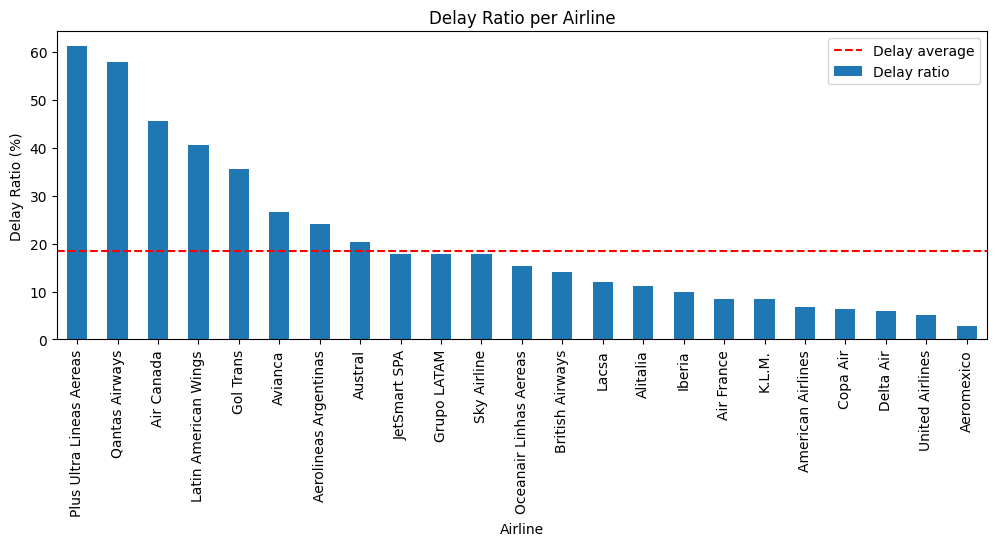

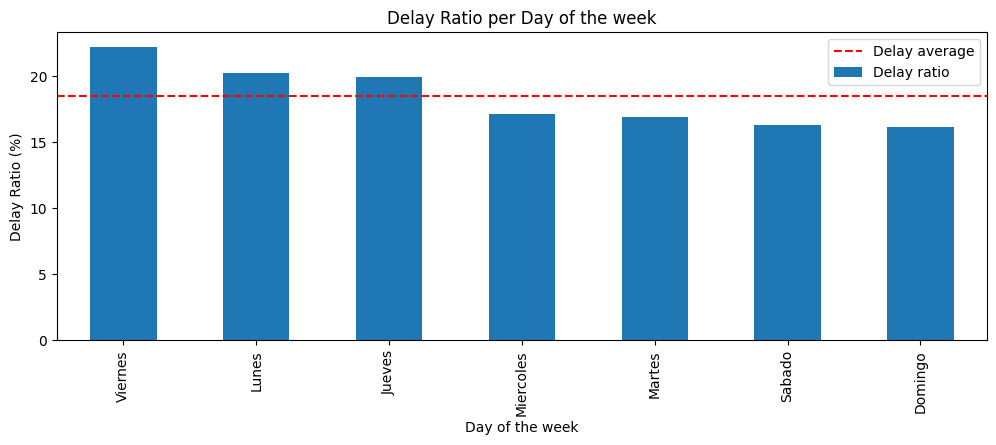

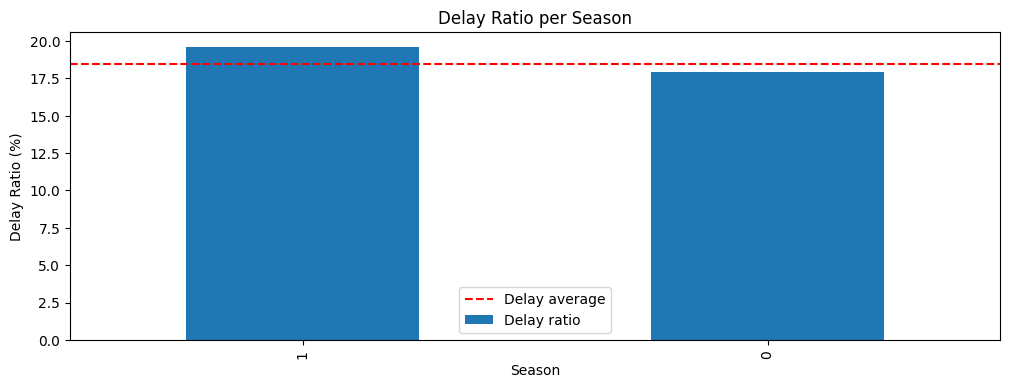

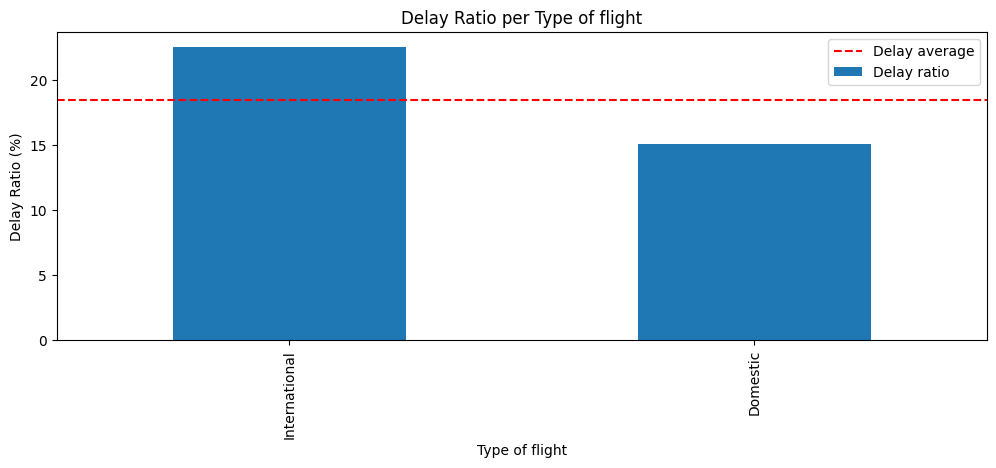

In [10]:
plot_ratio(df = df, feature = 'SIGLADES', title = 'Delay Ratio per Destination', xlabel = 'Destination')
plot_ratio(df = df, feature = 'MES', title = 'Delay Ratio per Month', xlabel = 'Month')
plot_ratio(df = df, feature = 'OPERA', title = 'Delay Ratio per Airline', xlabel = 'Airline')
plot_ratio(df = df, feature = 'DIANOM', title = 'Delay Ratio per Day of the week', xlabel = 'Day of the week')
plot_ratio(df = df, feature = 'high_season', title = 'Delay Ratio per Season', xlabel = 'Season')
plot_ratio(df = df, feature = 'TIPOVUELO', title = 'Delay Ratio per Type of flight', xlabel = 'Type of flight')

From the previous graphs, we can conclude that:

- International and infrequent destinations (such as `Cochabamba` and `Puerto Stanley`) are more likely to be delayed.
- The months with the highest delay rates are `July`, `December`, and `October`.
- `Plus Ultra Lineas Aereas` has the highest delay rate, followed by `Qantas Airways`. In general, foreign airlines have a higher delay rate than local airlines.
- `Friday` is the day with the highest incidence of delays, followed by `Monday` and `Thursday`.
- `High-season` flights have a higher delay rate than `Low-season` flights.
- `International` flights are more likely to be delayed than `Domestic` flights.

Finally, it's important to mention that when it comes to predicting delays, it is expected that the most influential factors will be `International` flights, `Airlines` (particularly those that operate international flights), and the `day of the week` (with `Fridays` having a higher likelihood of delays).

# 4. Likelihood of delay

## Pre processing `Pipeline`

Before training our machine learning models, we will create a `Pipeline` that allows us to preprocess our data properly according to the type of feature.

Upon observing our data, we note that most of the columns are nominal categorical, except for the `DIA`, `MES`, and `AÑO` variables, which are ordinal categorical. Therefore, to encode these variables, we will use `OrdinalEncoder`, while for the rest, we will use `OneHotEncoder` to transform them into their corresponding one-hot encoding.

In order to generate interactions between the categorical variables, we attempted to use `PolynomialFeatures` in conjunction with `SelectPercentile` to select the top 10% of features with the most influence using the `chi2` test. This would reduce the number of features and thereby avoid the problem of the *curse of dimensionality*. Despite several attempts, this technique did not significantly improve the model, so it was disabled in the final `Pipeline`.

Lastly, we will use some of the features generated on Q2: `high_season` and `period_day`. It is important to notice that we can't use `min_diff` and `delay_15` because it is data that we won't have available before the delay.

In [11]:
# first, we transform DIA, MES, AÑO to categorical
df['AÑO'] = pd.Categorical(df['AÑO'])
df['MES'] = pd.Categorical(df['MES'])
df['DIA'] = pd.Categorical(df['DIA'])
df['high_season'] = pd.Categorical(df['high_season'])
df['period_day'] = pd.Categorical(df['period_day'])

ordinal_vars = ['DIA', 'MES', 'AÑO']
ordinal_cat = [[category for category in df[var].cat.categories] for var in ordinal_vars]
categoric_vars = [column for column in df.select_dtypes('category').columns if column not in ordinal_vars]

# we define pipelines for each data type
categoric_pipe = Pipeline([
                         ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Null')), # impute missing values
                         ('onehot', OneHotEncoder(handle_unknown = 'ignore')), # one hot encoding
                         #('interactions', PolynomialFeatures(include_bias = False, interaction_only = True)), # generate interactions
                         #('filter', SelectPercentile(score_func = chi2, percentile = 10)) # filter variables
                         ])

ordinal_pipe = Pipeline([
                         ('encoder', OrdinalEncoder(categories = ordinal_cat)), # ordinal encoding
                         ])

# we use the pipelines together with ColumnTransformer
preprocessor = ColumnTransformer([
                                  ('categoric', categoric_pipe, categoric_vars), # categoric pre processing
                                  ('ordinal', ordinal_pipe, ordinal_vars) # ordinal pre processing
])

## Baseline model

In order to have a point of comparison to later evaluate the quality of our models, we will use a `DummyClassifier` model as a benchmark, which generates its predictions using the class proportion in the dataset

In [12]:
baseline_pipe = Pipeline([
                  ('preprocessing', preprocessor),
                  ('clf', DummyClassifier(strategy = 'stratified')),
                  ])

evaluate_model(df = df, target = 'delay_15', pipeline = baseline_pipe, random_state = 3380)

F1: 0.500
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     18345
           1       0.19      0.18      0.18      4163

    accuracy                           0.70     22508
   macro avg       0.50      0.50      0.50     22508
weighted avg       0.70      0.70      0.70     22508



As expected, we obtain results matching the proportion of labels along with a 70% of global `accuracy`.

## Training and Optimization

To solve the flight delay prediction problem, we will use the `XGBoost` and `LightGBM` models, which are known for belonging to the *ensemble* model family and achieving excellent results in empirical machine learning methods.

To train the models, we will use the `Optuna` library to search for the best hyperparameters for both models. This library is characterized by using a search methodology based on Bayesian methods, achieving convergence to the best combination of hyperparameters more efficiently than methods such as `GridSearch`.

Regarding the *Holdout* of the data, we will use a 2:1 ratio for the train-test data split. An important point to note is that, since we use the `KFold Cross Validation` technique in combination with `Optuna`, we will not explicitly divide a validation set.

Finally, and considering the class imbalance, we will optimize the models by seeking to maximize the `F1_macro` metric, which is a measure that weighs the *precision* and *recall* of each class according to its frequency in the total dataset, allowing for greater importance to be given to minority classes in the model evaluation. Furthermore, we will *undersample* the data with `RandomUnderSampler` (see **resample.py**) in order to avoid over representation of the majority class. 

In [13]:
target = 'delay_15'
y = df[target]
X = df.drop(columns = target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 3380, stratify = y)

preprocessing_pipe = Pipeline([
                  ('preprocessing', preprocessor),
                  ])

n_trials = 100


In [14]:
# LightGBM Optimization

def objective(trial):
    params = {
        'param_under': trial.suggest_float(name = 'param_under', low = 0.0, high = 1.0, step = 0.05),
        'fit_weights': trial.suggest_categorical(name = 'fit_weights', choices = [True, False]),
        "n_estimators" : trial.suggest_int('lgbm_n_estimators', 50, 500),
        "learning_rate": trial.suggest_float("lgbm_learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("lgbm_num_leaves", 20, 3000, step = 20),
        "max_depth": trial.suggest_int("lgbm_max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("lgbm_min_child_samples", 200, 10000, step = 100),
        'reg_alpha': trial.suggest_loguniform('lgbm_reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('lgbm_reg_lambda', 1e-8, 1.0),
        "min_split_gain": trial.suggest_float("lgbm_min_split_gain", 0, 15),
        "subsample": trial.suggest_float("lgbm_subsample", 0.2, 0.95, step = 0.1),
        "subsample_freq": trial.suggest_categorical("lgbm_subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("lgbm_colsample_bytree", 0.2, 0.95, step = 0.1)
    }
        
    return optimize_lgbm(X_train = X_train, y_train = y_train, base_pipeline = preprocessing_pipe, random_state = random_state, **params)

study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = n_trials, show_progress_bar = True)

best_lgbm = study.best_trial
print(f'Best params: {best_lgbm.params}')
print(f'Best score: {best_lgbm.value}')

Best trial: 54. Best value: 0.600458: 100%|██████████| 100/100 [05:10<00:00,  3.11s/it]

Best params: {'param_under': 0.25, 'fit_weights': False, 'lgbm_n_estimators': 160, 'lgbm_learning_rate': 0.1435232610596412, 'lgbm_num_leaves': 1300, 'lgbm_max_depth': 5, 'lgbm_min_child_samples': 200, 'lgbm_reg_alpha': 0.13092633352012564, 'lgbm_reg_lambda': 4.217436145947237e-05, 'lgbm_min_split_gain': 14.57868708637263, 'lgbm_subsample': 0.5, 'lgbm_subsample_freq': 1, 'lgbm_colsample_bytree': 0.5}
Best score: 0.6004578094511064


In [15]:
# XGBoost Optimization

def objective(trial):
    params = {
        'param_under': trial.suggest_float(name = 'param_under', low = 0.0, high = 1.0, step = 0.05),
        'fit_weights': trial.suggest_categorical(name = 'fit_weights', choices = [True, False]),
        'max_depth': trial.suggest_int(name = 'xgboost_max_depth', low = 3, high = 10),
        'learning_rate': trial.suggest_loguniform('xgboost_learning_rate', 0.01, 0.5),
        "n_estimators" : trial.suggest_int('xgboost_n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('xgboost_min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('xgboost_gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('xgboost_subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('xgboost_colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('xgboost_reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('xgboost_reg_lambda', 1e-8, 1.0),
        }
    
    return optimize_xgboost(X_train = X_train, y_train = y_train, base_pipeline = preprocessing_pipe, random_state = random_state, **params)

study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = n_trials, show_progress_bar = True)

best_xgboost = study.best_trial
print(f'Best params: {best_xgboost.params}')
print(f'Best score: {best_xgboost.value}')

Best trial: 15. Best value: 0.668043: 100%|██████████| 100/100 [1:10:22<00:00, 42.22s/it]

Best params: {'param_under': 0.25, 'fit_weights': True, 'xgboost_max_depth': 9, 'xgboost_learning_rate': 0.053062789176108446, 'xgboost_n_estimators': 412, 'xgboost_min_child_weight': 6, 'xgboost_gamma': 0.01477373669136935, 'xgboost_subsample': 0.9138054965274212, 'xgboost_colsample_bytree': 0.5190409401716449, 'xgboost_reg_alpha': 5.763188059332675e-06, 'xgboost_reg_lambda': 0.0003721916229794655}
Best score: 0.6680430278134151


## Export models

In [17]:
# LightGBM
processing_params = {key: value for key, value in best_lgbm.params.items() if 'lgbm' not in  key.split('_')}
lgbm_params = {key.replace('lgbm_', ''): value for key, value in best_lgbm.params.items() if 'lgbm' in key.split('_')} # selected params

best_pipeline_gbm = Pipeline([ # generate a pipeline
                  ('preprocessing', preprocessor),
                  ('clf', LGBMClassifier(random_state = random_state, **lgbm_params)), # using the best params
                  ])

evaluate_model(df = df, target = 'delay_15', pipeline = best_pipeline_gbm, random_state = random_state, **processing_params, report = False) # evaluate the model with the selected params

# XGBoost
processing_params = {key: value for key, value in best_xgboost.params.items() if 'xgboost' not in  key.split('_')}
xgboost_params = {key.replace('xgboost_', ''): value for key, value in best_xgboost.params.items() if 'xgboost' in key.split('_')} # selected params

best_pipeline_xgboost = Pipeline([ # generate a pipeline
                  ('preprocessing', preprocessor),
                  ('clf', XGBClassifier(random_state = random_state, **xgboost_params)), # using the best params
                  ])

evaluate_model(df = df, target = 'delay_15', pipeline = best_pipeline_xgboost, random_state = random_state, **processing_params, report = False) # evaluate the model with the selected params


# Export

pickle.dump(best_pipeline_gbm, open('models/lgbm_optimized.pkl', 'wb'))
pickle.dump(best_pipeline_xgboost, open('models/xgb_optimized.pkl', 'wb'))

# 5. Evaluate performance and Discussion

Having selected the best model and hyperparameters, we will use them to predict the test set. 

As previously mentioned, it's useful to utilize the `f1_macro` metric for evaluating model performance because it gives equal importance to both *True Negatives* and *True Positives*. This is particularly important because we want a model that can accurately predict flight delays while still being able to predict when a flight **won't** be delayed.

In [18]:
evaluate_model(df = df, target = 'delay_15', pipeline = best_pipeline_xgboost, random_state = random_state, **processing_params) # evaluate the model with the selected params

F1: 0.597
              precision    recall  f1-score   support

           0       0.90      0.67      0.77     18345
           1       0.31      0.66      0.42      4163

    accuracy                           0.67     22508
   macro avg       0.61      0.67      0.60     22508
weighted avg       0.79      0.67      0.71     22508



Let's now evaluate the most influential variables on the model. For that, we will use the `features importances` of the model:

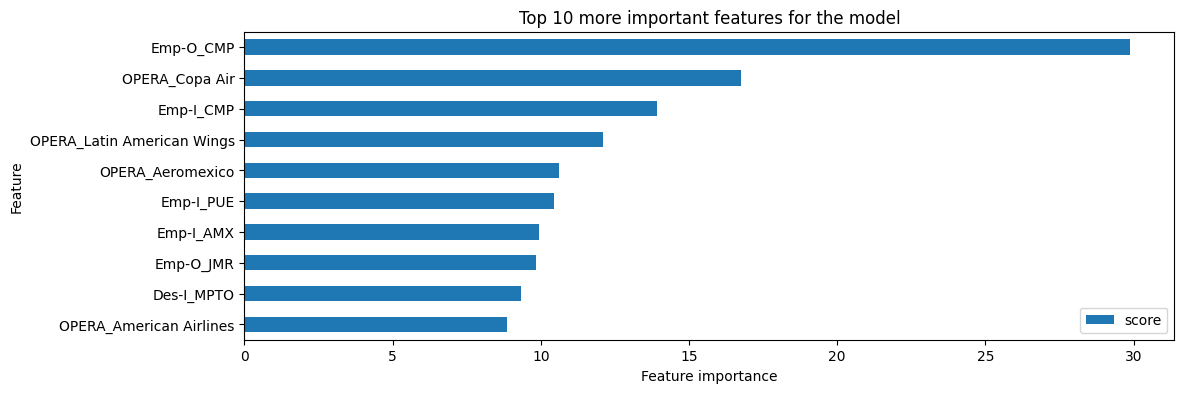

In [19]:
# features passed to the model
model_vars = categoric_vars + ordinal_vars # categorical + ordinal vars
vars_dict = {f'x{i}': model_vars[i] for i in range(len(model_vars))} # dict: {x0: feature_0, ...}

# we recover the features names of the preprocessing step
onehot_features = best_pipeline_xgboost['preprocessing'].transformers_[0][1]['onehot'].get_feature_names_out() # features names in format: [x1_category1, ...]
onehot_features = ['_'.join([vars_dict[i] if i in vars_dict.keys() else i for i in feature.split('_')]) for feature in onehot_features] # categoric features names in format: [feature1_category1, ...]

ordinal_features = best_pipeline_xgboost['preprocessing'].transformers_[1][1]['encoder'].get_feature_names_out() # ordinal features names

# generate a dict to transform map features from xgboost to the original names
features_names = list(onehot_features) + list(ordinal_features) # features names
features_dict = {f'f{i}': features_names[i] for i in range(len(features_names))} # 

# we get the features importances of the model
importances = best_pipeline_xgboost['clf'].get_booster().get_score(importance_type = 'gain') # importances in format: {f1: value1, ...}
keys = [features_dict[key] for key in importances.keys()] # recover original names
values = list(importances.values()) # importances values

# plot
data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = False)
data.nlargest(10, columns = "score").sort_values(by = 'score', ascending = True).plot(kind = 'barh', figsize = (12,4)) 
plt.title('Top 10 more important features for the model')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

We can observe that the variables with the highest level of influence were `EMP-O_CMP`, `OPERA_Copa Air`, and `EMP-I_CMP`, all of which indicate that the flight was operated by the `Opera Air` airline. Following these, we have `OPERA_Latin American Wings` and `OPERA_Aeromexico`, which refer to flights operated by the `Latin American Wings` and `Aeromexico` airlines, respectively.

In terms of the model's ability to predict flights delay, it is noteworthy that the selected model performs better than the baseline. It achieved an *F1* score of 0.597, compared to the baseline's score of 0.5, although this resulted in a slight reduction in the overall accuracy to 67%, compared to the baseline's 70%. Based on the *recall* obtained, it is possible to conclude that our model accurately identifies 66% of delayed flights.

Lastly, the presented model can be improved by following these guidelines:

- Increase the sample size: Training the classifier with more data enhances the model's ability to generalize, leading to better predictions. One quick way to achieve this is by including the entire historical series of flights (i.e., including other years besides 2017).
- Increase the number of features: Having more features enables the model to generalize better, increasing its predictive power. For example, weather forecasts could be included to monitor the conditions for the airplane to take off.
- Further explore *feature engineering*: Although interactions between all available categories were tested, more features could be generated to better separate the classes. A good option is to review studies and literature to identify which features would be important for the decision-making process.
- Use *deep learning*: Deep learning models have the ability to generate their own features (representation learning), making them a good choice for seeking better metrics in predicting flight delays. However, a disadvantage of using these models is that they can be difficult to interpret, which is often important for the business.